In [ ]:
root_dir = '/content/drive/MyDrive/TimeseriesPrediction'
data_dir = '/content/drive/MyDrive/data'
# !ls drive/MyDrive/TimeseriesPrediction

import os
import sys
sys.path.append(root_dir)
sys.path.append(data_dir)

In [ ]:
import time
import json
import pickle
import logging

In [ ]:
# !pip install git+https://github.com/Lightning-AI/metrics.git@release/stable

In [ ]:
log_dir = None # Specify the directory to continue a previous experiment.

if log_dir == None:
  model_name = "VanillaLSTM"
  model_version = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())  # datetime

  log_dir = os.path.join(root_dir, model_name, model_version)
  os.makedirs(log_dir, exist_ok=True)

In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format="%(name)s - %(message)s",
    handlers=[
        logging.FileHandler(os.path.join(log_dir, 'logs')),
        logging.StreamHandler()
    ],
    force=True  # without force set, basicConfig not working
)


In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import tensorboard

import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from timeseries_dataset import TimeSeriesDataset
from lstm_models import LSTM, SocialLSTM # renamed 
from solver import Solver
# from hyperparameter_tuning import random_search


numexpr.utils - NumExpr defaulting to 2 threads.


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
#config_load_file = os.path.join(logging_dir, "config.pkl") 
config_load_file = None

if config_load_file:
  with open(config_load_file, 'rb') as f:
    config = pickle.load(f)
else:
  # Params not defined in 'config' use default values 

  config = {
      "data_config": {
          "input_len": 10,
          "output_len": 1,
          "stride": 10,
          "lag": 10
      },
      "model_config": {
          "input_size": 232, # #features (232) - #appliances (21) + 1
          "embedding_size": 256,
          "hidden_size" : 256,
          "num_layer" : 1
      },
      "train_config": {
          "optimizer": optim.Adam,
          "learning_rate": 1e-4, 
          "optim_scheduler": StepLR,
          "lr_decay": 0.3,
          "step_size": 3
      }
  }

data_config = config['data_config']
model_config = config['model_config']
train_config = config['train_config']

In [ ]:
power_path = os.path.join(data_dir, "Electricity_P.csv")
weather_path = os.path.join(data_dir, "Climate_HourlyWeather.csv")

In [ ]:
train_dataset = TimeSeriesDataset(power_path, weather_path, 
                                  input_len = data_config['input_len'], 
                                  output_len = data_config['output_len'],
                                  stride = data_config['stride'],
                                  lag = data_config["lag"], 
                                  mode = 'train')
train_dataloader = DataLoader(train_dataset, batch_size=1)


In [ ]:
val_dataset = TimeSeriesDataset(power_path, weather_path, 
                                input_len = data_config['input_len'], 
                                output_len = data_config['output_len'],
                                stride = data_config['stride'],
                                lag = data_config["lag"],
                                scaler = train_dataset.num_scaler,
                                weather_encoder = train_dataset.weather_encoder,
                                datetime_encoder = train_dataset.datetime_encoder,
                                mode = 'val')
val_dataloader = DataLoader(val_dataset, batch_size=1)

In [ ]:
output_scaler = {"scale": train_dataset.num_scaler.scale_[8],
                 "mean": train_dataset.num_scaler.mean_[8]}

if config_load_file == None:
  config['data_config']['scaler'] = train_dataset.num_scaler
  config['data_config']['weather_encoder'] = train_dataset.weather_encoder
  config['data_config']['datetime_encoder'] = train_dataset.datetime_encoder

  config['train_config']['output_scaler'] = output_scaler

In [ ]:
if config_load_file == None:
  config_save_file = os.path.join(logging_dir, "config.pkl")

  with open(config_save_file, 'wb') as f:
    pickle.dump(config, f)

In [ ]:
writer = SummaryWriter('runs/electricity_forecasting')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = LSTM(device = device,
                     input_size=model_config['input_size'],
                     embedding_size=model_config['embedding_size'], 
                     hidden_size=model_config['hidden_size'],
                     num_layer=model_config['num_layer'])

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
optimizer = train_config['optimizer'](model.parameters(), train_config['learning_rate'])
# TODO: test this scheduler (saving and loading)
optim_scheduler = train_config['optim_scheduler'](optimizer, train_config['step_size'], train_config['lr_decay'])

In [ ]:
model_load_file = None

if model_load_file:
  checkpoint = torch.load(model_load_file, map_location=device)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  optim_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  
  # reset learning rate:
  # for param_group in optimizer.param_groups:
  #       param_group["lr"] = lr

  # loss stats (see log file) not exactly the same, 
  # has to do with learning rate?

solver - Train starts
solver - Iteration [6000]: elapsed time 17.82s, training loss 269464.53005
solver - Iteration [12000]: elapsed time 16.31s, training loss 153161.37786
solver - Iteration [18000]: elapsed time 15.91s, training loss 127254.06859
solver - Iteration [24000]: elapsed time 16.78s, training loss 128596.44127
solver - Iteration [30000]: elapsed time 15.96s, training loss 128585.85568
solver - Iteration [36000]: elapsed time 16.35s, training loss 148632.64065
solver - Iteration [42000]: elapsed time 16.21s, training loss 132571.17090
solver - Iteration [48000]: elapsed time 15.81s, training loss 179609.95791
solver - Iteration [54000]: elapsed time 15.86s, training loss 180270.05348
solver - Iteration [60000]: elapsed time 15.73s, training loss 132991.00216
solver - Iteration [63071]: elapsed time 8.42s, training loss 144856.42385
solver - Eval
solver - Iteration [500]: elapsed time 0.47(s), eval loss 102792.11878
solver - Iteration [1000]: elapsed time 0.47(s), eval loss 

Saving model to  /content/drive/MyDrive/TimeseriesPrediction/VanillaLSTM/2023-05-09 19:07:20/models/model-0


solver - Iteration [6000]: elapsed time 16.27s, training loss 145408.67519
solver - Iteration [12000]: elapsed time 15.81s, training loss 127955.81131
solver - Iteration [18000]: elapsed time 15.92s, training loss 110347.37977
solver - Iteration [24000]: elapsed time 15.73s, training loss 115774.35462
solver - Iteration [30000]: elapsed time 15.78s, training loss 119134.56325
solver - Iteration [36000]: elapsed time 16.02s, training loss 135463.72654
solver - Iteration [42000]: elapsed time 16.16s, training loss 118461.81048
solver - Iteration [48000]: elapsed time 15.81s, training loss 164842.02875
solver - Iteration [54000]: elapsed time 15.85s, training loss 166883.92856
solver - Iteration [60000]: elapsed time 15.59s, training loss 121858.87115
solver - Iteration [63071]: elapsed time 8.31s, training loss 133824.70150
solver - Eval
solver - Iteration [500]: elapsed time 0.45(s), eval loss 107385.46051
solver - Iteration [1000]: elapsed time 0.47(s), eval loss 184129.72274
solver - 

Saving model to  /content/drive/MyDrive/TimeseriesPrediction/VanillaLSTM/2023-05-09 19:07:20/models/model-1


solver - Iteration [6000]: elapsed time 16.05s, training loss 133590.43336
solver - Iteration [12000]: elapsed time 15.83s, training loss 112336.10062
solver - Iteration [18000]: elapsed time 15.65s, training loss 104219.00367
solver - Iteration [24000]: elapsed time 15.73s, training loss 109275.15001
solver - Iteration [30000]: elapsed time 15.78s, training loss 110774.21215
solver - Iteration [36000]: elapsed time 15.83s, training loss 127177.46020
solver - Iteration [42000]: elapsed time 16.26s, training loss 110856.01445
solver - Iteration [48000]: elapsed time 16.13s, training loss 152022.24918
solver - Iteration [54000]: elapsed time 15.95s, training loss 157426.81532
solver - Iteration [60000]: elapsed time 15.86s, training loss 110364.87478
solver - Iteration [63071]: elapsed time 8.48s, training loss 121845.00744
solver - Eval
solver - Iteration [500]: elapsed time 0.45(s), eval loss 143548.95824
solver - Iteration [1000]: elapsed time 0.46(s), eval loss 206865.94280
solver - 

Saving model to  /content/drive/MyDrive/TimeseriesPrediction/VanillaLSTM/2023-05-09 19:07:20/models/model-2


solver - Iteration [6000]: elapsed time 16.25s, training loss 120874.18288
solver - Iteration [12000]: elapsed time 15.91s, training loss 97855.90650
solver - Iteration [18000]: elapsed time 15.79s, training loss 95898.07115
solver - Iteration [24000]: elapsed time 15.76s, training loss 97823.11213
solver - Iteration [30000]: elapsed time 15.78s, training loss 101395.70170
solver - Iteration [36000]: elapsed time 15.94s, training loss 117885.84492
solver - Iteration [42000]: elapsed time 16.22s, training loss 95478.08427
solver - Iteration [48000]: elapsed time 15.76s, training loss 130002.49462
solver - Iteration [54000]: elapsed time 15.68s, training loss 138188.77328
solver - Iteration [60000]: elapsed time 15.71s, training loss 92387.56438
solver - Iteration [63071]: elapsed time 8.39s, training loss 96488.90149
solver - Eval
solver - Iteration [500]: elapsed time 0.47(s), eval loss 154909.31378
solver - Iteration [1000]: elapsed time 0.46(s), eval loss 215570.45445
solver - Iterat

Saving model to  /content/drive/MyDrive/TimeseriesPrediction/VanillaLSTM/2023-05-09 19:07:20/models/model-3


solver - Iteration [6000]: elapsed time 15.79s, training loss 112768.49501
solver - Iteration [12000]: elapsed time 16.18s, training loss 90647.07985
solver - Iteration [18000]: elapsed time 15.76s, training loss 90354.89620
solver - Iteration [24000]: elapsed time 15.77s, training loss 91115.70346
solver - Iteration [30000]: elapsed time 15.71s, training loss 95660.49696
solver - Iteration [36000]: elapsed time 15.84s, training loss 111588.49541
solver - Iteration [42000]: elapsed time 16.48s, training loss 88904.92938
solver - Iteration [48000]: elapsed time 15.81s, training loss 120230.94508
solver - Iteration [54000]: elapsed time 15.63s, training loss 130240.57858
solver - Iteration [60000]: elapsed time 15.86s, training loss 85727.37955
solver - Iteration [63071]: elapsed time 8.41s, training loss 89101.04764
solver - Eval
solver - Iteration [500]: elapsed time 0.46(s), eval loss 147203.52621
solver - Iteration [1000]: elapsed time 0.47(s), eval loss 213493.43899
solver - Iterati

Saving model to  /content/drive/MyDrive/TimeseriesPrediction/VanillaLSTM/2023-05-09 19:07:20/models/model-4


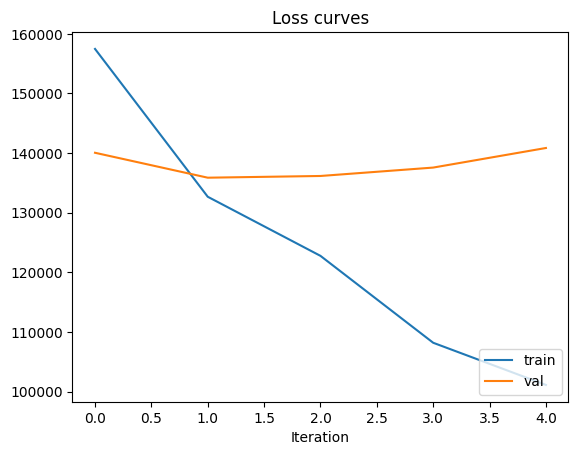

In [ ]:
epochs = 20

solver = Solver(model,
          optimizer=optimizer,
          optim_scheduler=optim_scheduler)

#solver.evaluate(val_dataloader, train_dataset.num_scaler.scale_[8], train_dataset.num_scaler.mean_[8],visualize=True)
solver.train(train_dataloader, 
          val_dataloader, 
          output_scaler,
          epochs, 
          epoch_start=(checkpoint['epoch']+1) if model_load_file else 0, 
          print_freq = 6000,
          patience=3, 
          validate_first_epoch = False)

plt.title('Loss curves')
plt.plot(solver.train_loss_history, '-', label='train')
plt.plot(solver.val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.show()

Evaluate the model on test set

In [ ]:
test_dataset = TimeSeriesDataset(power_path, weather_path, 
                                input_len = data_config['input_len'], 
                                output_len = data_config['output_len'],
                                stride = data_config['stride'],
                                lag = data_config["lag"],
                                scaler = train_dataset.num_scaler,
                                weather_encoder = train_dataset.weather_encoder,
                                datetime_encoder = train_dataset.datetime_encoder,
                                mode = 'test')
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [ ]:
test_model = LSTM(device = device,
                     input_size=model_config['input_size'],
                     embedding_size=model_config['embedding_size'], 
                     hidden_size=model_config['hidden_size'],
                     num_layer=model_config['num_layer'])

test_model = test_model.to(device)

model_path = os.path.join(log_dir, "models", "model-1")
# model_path = '/content/drive/MyDrive/TimeseriesPrediction/VanillaLSTM/2023-04-26 14:56:25/models/model-3'
checkpoint = torch.load(model_path, map_location=device)

test_model.load_state_dict(checkpoint['state_dict'])
test_model = test_model.to(device)



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
solver.evaluate(test_dataloader, output_scaler, visualize=False)

solver - Eval
solver - Iteration [500]: elapsed time 0.48(s), eval loss 107207.32385
solver - Iteration [1000]: elapsed time 0.47(s), eval loss 125336.63147
solver - Iteration [1500]: elapsed time 0.48(s), eval loss 143707.50883
solver - Iteration [2000]: elapsed time 0.47(s), eval loss 179035.44507
solver - Iteration [2500]: elapsed time 0.48(s), eval loss 153559.83182
solver - Iteration [3000]: elapsed time 0.46(s), eval loss 192390.66528
solver - Iteration [3500]: elapsed time 0.48(s), eval loss 175322.49888
solver - Iteration [4000]: elapsed time 0.47(s), eval loss 168604.44908
solver - Iteration [4500]: elapsed time 0.47(s), eval loss 169894.44293
solver - Iteration [5000]: elapsed time 0.46(s), eval loss 161954.70122
solver - Iteration [5500]: elapsed time 0.47(s), eval loss 151824.19765
solver - Iteration [6000]: elapsed time 0.47(s), eval loss 152112.69846
solver - Iteration [6500]: elapsed time 0.46(s), eval loss 148934.74465
solver - Iteration [7000]: elapsed time 0.47(s), ev

159752.14998760898